In [114]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.signal import find_peaks
from scipy import optimize
from scipy.signal import savgol_filter


In [115]:
@njit
def findPeaks(x,n):
    topsi = []
    valleysi = []
    tops = []
    valleys = []
    for i in range(n,len(x)-n):
        ct = 0; cb = 0
        for j in range(-n,n+1):           
            if (x[i]>x[i+j]):
                ct += 1
            if (x[i]<x[i+j]):
                cb += 1
       
        if ct == 2*n:
            tops.append(x[i])
            topsi.append(i)
        elif cb == 2*n:
            valleys.append(x[i])
            valleysi.append(i)
    return np.array(tops),np.array(valleys),np.array(topsi),np.array(valleysi)



import numpy as np
from numba import jit

# Peak finding function using Numba
@jit(nopython=True)
def find_peaks(arr):
    peaks = []
    n = len(arr)
    
    # Handle the first and last element separately if necessary
    if n > 1:
        # Check the first point
        if arr[0] > arr[1]:
            peaks.append(0)
        
        # Check the last point
        if arr[-1] > arr[-2]:
            peaks.append(n - 1)

        # Check the points in the middle
        for i in range(1, n - 1):
            if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
                peaks.append(i)

    return peaks


0.05735547705490472 0.5295443592931989 3.990708707222649 0.024158165469943375
tc true 2.2371832884203857


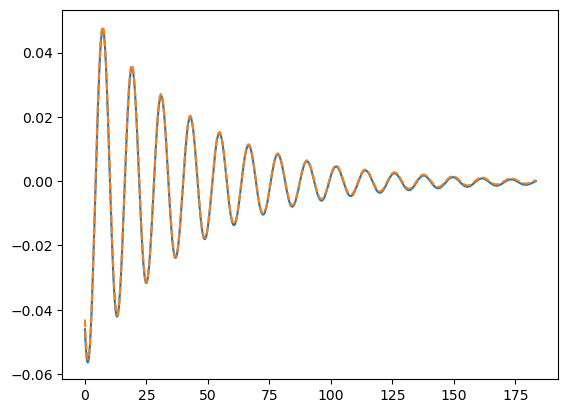

In [116]:
@njit
def Simp53(omega,A,OM,TC,a0,b0,c0,d0,e0,f0,g0):
    
    a = a0
    b = b0
    c = c0
    d = d0
    e = e0
    f = f0
    g = g0
    
    #a = 3.
    #b = 4.5
    #c = 0.5
    #d = 0.3
    #e = 1
    #f = 1
    #g = 0.7

    Tmax = 250
    t = 0; dt = .001; ts = 1./6; click = 0; Saf = np.zeros((int(Tmax/ts)+1,3));


    p = 0; m =2; M = 1;
    nut = 0
    while t < Tmax:
        

        nut =  A/2*(1+np.sign(np.sin(2*np.pi/omega*t)))
        k = 1/(1+nut)
        dp = a - b/(1+1*nut)*M*p/(p + k*c);
        dm = d*p**2 - e*m
        dM = f*m - g*M;
        
        t += dt
        p += dt*dp
        m += dt*dm
        M += dt*dM
        
        if (t > click*ts):
            Saf[click,0] = t
            Saf[click,1] = p
            Saf[click,2] = nut
            click += 1
    return Saf
        
OM = 1.5
om = 5.5
AA = 0.0;
TC = 1

a0 = .5
b0 = 2
c0 = .23
d0 = .4
e0 = .4
f0 = .4
g0 = .3

print()

Saf = Simp53(om,AA,OM,TC,a0,b0,c0,d0,e0,f0,g0)
x = Saf[400:,1]
t = Saf[400:,0]
x = x - x[-1]
t = t - t[0]
nut = Saf[:,2]
plt.plot(t,x)


def test_func_osci(t, a, b,c,d):
    return a*np.sin(b * t + c)*np.exp(-d*t)
params_decay, params_covariance_decay = optimize.curve_fit(test_func_osci, t, x,bounds=([0,2*np.pi/20,0,0], [np.max([np.max(x)*1.1,30]), 2*np.pi/1, 2*np.pi,10]),
            p0=[np.max(x), 2*np.pi/5.5,np.pi,0.1])
a = params_decay[0]
b = params_decay[1]
c = params_decay[2]
d = params_decay[3]
print(a,b,c,d)
plt.plot(t,test_func_osci(t, a, b,c,d),'--')
################## Rescale TC #################
n = 20
tops,valleys,topsi,valleysi = findPeaks(x,n)
Per = t[topsi[1:]]-t[topsi[:-1]]
TC = TC*np.mean(Per)/5.3
print('tc true',TC)

In [128]:
print(TC)
########### Data ################

T = np.array([2.5,4,5.5,7,11])
A =  np.array([0.47954555, 0.4514159 , 1.02126127 ,0.48698371, 0.55021768])
SA1 =np.array([0.42933198, 0.26060091, 0.76892771 ,0.68091041 ,0.45633722])
NN = np.array([124.,  58.,  96., 289., 188.])

SA = SA1/np.sqrt(NN)
####################################

OM = 2.8
AA = .35

a0 = 3.
b0 = 4.5
c0 = 0.5
d0 = 0.3
e0 = 1
f0 = 1
g0 = 0.7

at = a0
bt = b0
ct = c0
dt = d0
et = e0
ft = f0
gt = g0

AAt = AA
        
Saf = Simp53(om,AAt,OM,TC,at,bt,ct,dt,et,ft,gt)

AM = []
n = 10

@njit(parallel = True)
def multiple_loops_RW(N_loops,Omegas,a0,b0,c0,d0,e0,f0,g0,AA,noise,TC):
    L = len(Omegas)
    AM = np.zeros((L,N_loops))
    com = 0
    for com in prange(len(Omegas)):
        om = Omegas[com]
        for test in prange(N_loops):
            at = a0*(1+noise*np.random.normal())
            bt = b0*(1+noise*np.random.normal())
            ct = c0*(1+noise*np.random.normal())
            dt = d0*(1+noise*np.random.normal())
            et = e0*(1+noise*np.random.normal())
            ft = f0*(1+noise*np.random.normal())
            gt = g0*(1+noise*np.random.normal())
            AAt = AA*(1+2*noise*np.random.normal())
        
            Saf = Simp53(om,AAt,OM,TC,at,bt,ct,dt,et,ft,gt)
            
            x = Saf[:,1]
            t = Saf[:,0]
            x = x[1000:]
            AMP = 0.5*(np.max(x)-np.min(x))
            
            tops,valleys,topsi,valleysi = findPeaks(x,n)
            AMP_2 = (0.5*(np.mean(tops)-np.mean(valleys)))
            AM[com,test] = AMP
            #AM[com,test] = (0.5*peaks)
    return AM
Omegas = np.linspace(1,12,100)
N_loops = 100
noise = .05
AM = multiple_loops_RW(N_loops,Omegas,a0,b0,c0,d0,e0,f0,g0,AA,noise,TC)

################# Plotting ################    
AM = np.array(AM)

AMT = np.mean(AM,axis=0)


2.2371832884203857


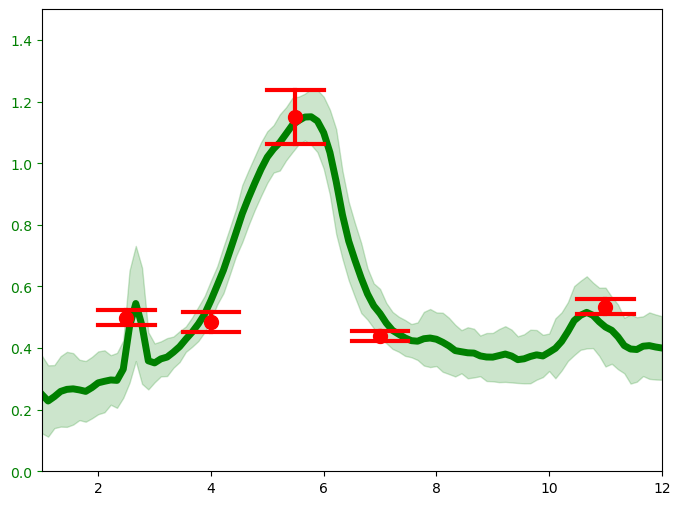

In [129]:

########### Data ################
T = np.array([2.5,4,5.5,7,11])
A =  np.array([0.47954555, 0.4514159 , 1.02126127 ,0.48698371, 0.55021768])
SA1 =np.array([0.42933198, 0.26060091, 0.76892771 ,0.68091041 ,0.45633722])
NN = np.array([124.,  58.,  96., 289., 188.])

A =  np.array([0.49911653, 0.4848074,  1.14917397, 0.4386294,  0.53372315])
SA1 =np.array([0.2660905,  0.25578251, 0.86790097, 0.27287341, 0.33796161])
NN = np.array([124.,  58.,  97. ,288., 188.])


SA = SA1/np.sqrt(NN)
####################################

fig, ax1 = plt.subplots(figsize=(8, 6))
y = np.mean(AM,axis=1)
y = savgol_filter(y, 5, 3)
ys = np.std(AM,axis=1)
ax1.plot(Omegas,y, 'g-',lw=5)
ax1.fill_between(Omegas, y - ys, y + ys, color='g', alpha=0.2)
ax1.tick_params('y', colors='g')

plt.plot(Omegas,y,'g',lw=3)
plt.plot(T,A,'or',markersize=10)
plt.plot([T,T],[A-SA,A+SA],'r',lw=3)
plt.plot([T-0.5,T+0.5],[A-SA,A-SA],'r',lw=3)
plt.plot([T-0.5,T+0.5],[A+SA,A+SA],'r',lw=3)
plt.axis([1,12,0,1.5])
plt.show()



2.5 0.22164253332815043


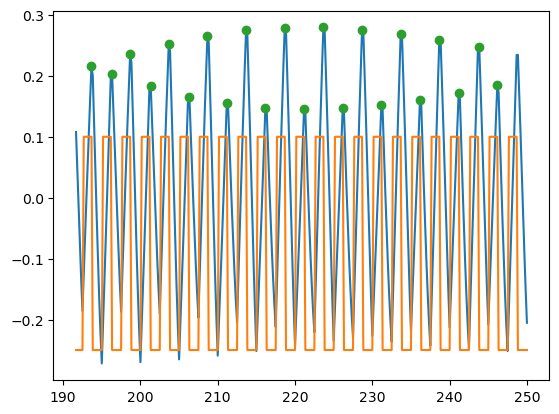

4 0.5583382427790794


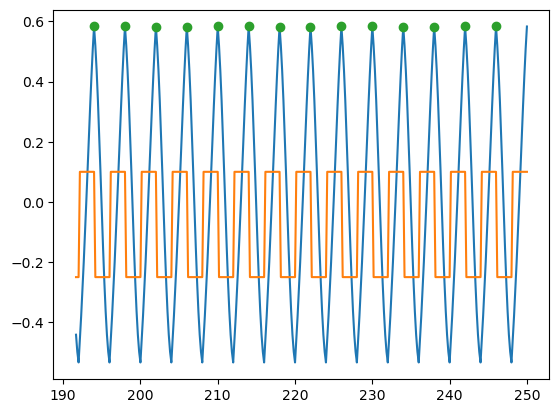

5.5 1.1295202768753114


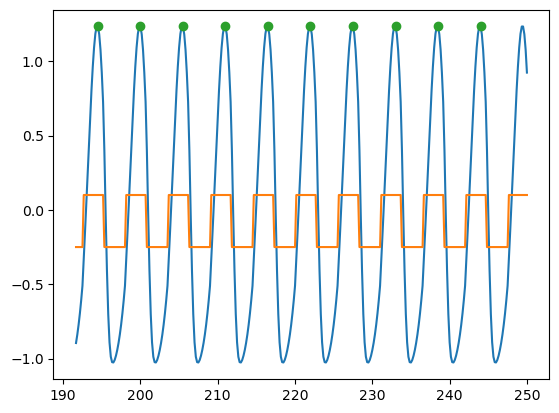

7 0.5005139087183723


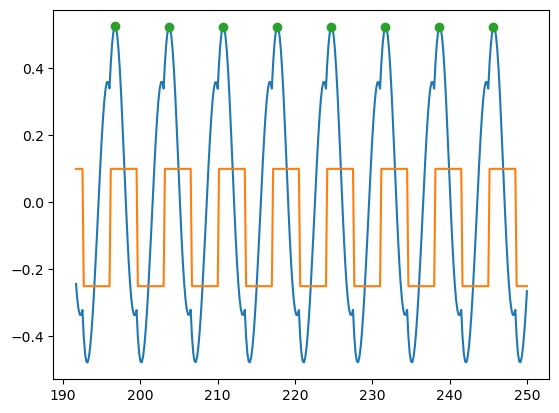

11 0.24887212763299893


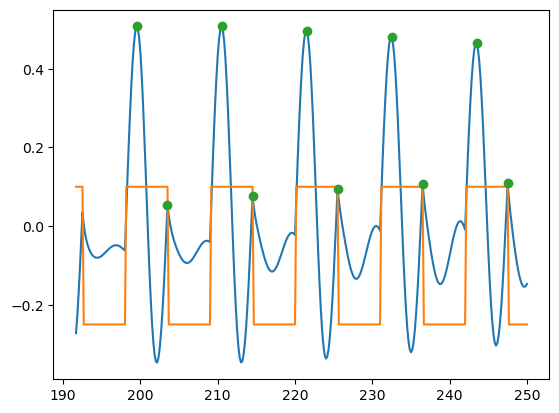

In [119]:
T = [2.5,4,5.5,7,11]
for om in T:
    tops = []; valleys = [];
 
    Saf = Simp53(om,AA,OM,TC,a0,b0,c0,d0,e0,f0,g0)
    x = Saf[:,1]
    t = Saf[:,0]  
    nut =  Saf[:,2]  
    #x = x/x[0];
    x = x[1150:]
    t = t[1150:]
    nut = nut[1150:]
    plt.plot(t,x-np.mean(x))
    plt.plot(t,nut-0.25)
    
    tops,valleys,topsi,valleysi = findPeaks(x,n)
    print(om,0.5*(np.mean(tops)-np.mean(valleys)))
    plt.plot(t[topsi],x[topsi]-np.mean(x),'o')
    plt.show()
plt.show()

In [439]:
import time
@njit
def RandWalk(D):
    dt = 0.001; t = 0; Tmax = 10;
    x = 0;
    while t <= Tmax:
        x += np.sqrt(2*D*dt)*np.random.normal()
        t = t + dt       
    return x

@njit(parallel = True)
def multiple_loops_RW(N_loops,DiffV):
    L = len(DiffV)
    AllF = np.zeros((L,N_loops))
    for i in prange(L):
        for j in prange(N_loops):
             AllF[i,j] = RandWalk(DiffV[i])
    return AllF

DiffV = np.linspace(0.1,1,100)
N_loops = 1000
start_time = time.time()
Var = multiple_loops_RW(N_loops,DiffV)
print("--- Loop was %s seconds ---" % (time.time() - start_time))
Var = np.array(Var)



--- Loop was 2.233976125717163 seconds ---


end
0.6554880993332663 0.37786147934553804 0.5784672561041403
end
0.5079983299421371 0.34053141020605543 0.6198873984885934
end
0.3633089983267483 0.5958363223531994 0.9030912683630227
end
0.9239127024198911 0.3939650459803712 0.4619128049765874
end
0.7992033876664063 0.4122596714282224 0.5319874605972573


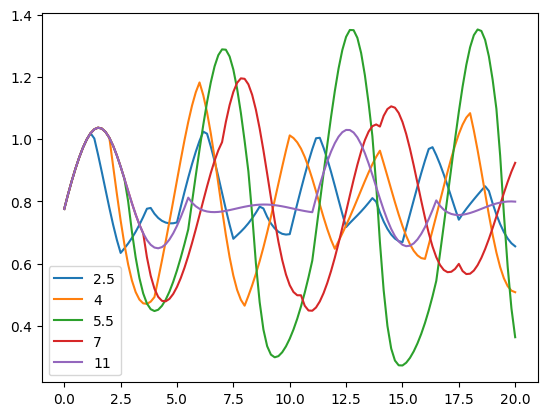

In [810]:
@njit
def Simp53_First(omega,A,OM,TC,a0,b0,c0,d0,e0,f0,g0):
    
    a = a0*TC*OM;
    b = b0*TC;
    c = c0*OM;
    d = d0*TC/OM;
    e = e0*TC;
    f = f0*TC;
    g = g0*TC
    
    Tmax = 20
    t = 0; dt = .001; ts = 1./6; click = 0; Saf = np.zeros((int(Tmax/ts)+1,3));

    p = 0.7755049336976674; m = 0.4009370578885167; M = 0.5345759207234092
    #p = 0; m =2; M = 1;
    nut = 0
    while t < Tmax:
        
        
        nut =  A/2*(1+np.sign(np.sin(2*np.pi/omega*t)))
        k = 1/(1+nut)
        dp = a - b/(1+1*nut)*M*p/(p + k*c);
        dm = d*p**2 - e*m
        dM = f*m - g*M;
        
        t += dt
        p += dt*dp
        m += dt*dm
        M += dt*dM
        
        if (t > click*ts):
            Saf[click,0] = t
            Saf[click,1] = p
            Saf[click,2] = nut
            click += 1
    print('end')
    print(p,m,M)
    return Saf
        
OM = 1.5
om = 5.5
AA = 0.3;
TC = 2.23

a0 = .5
b0 = 2
c0 = .22
d0 = .4
e0 = .4
f0 = .4
g0 = .3
T = [2.5,4,5.5,7,11]
for test in T:
    Saf = Simp53_First(test,AA,OM,TC,a0,b0,c0,d0,e0,f0,g0)
    x = Saf[:,1]
    t = Saf[:,0]
   
    
    nut = Saf[:,2]
    plt.plot(t,x,label='%s'%(test))
plt.legend()
plt.show()
